In [1]:
from keras import Input, layers
from keras.models import Model
import tensorflow as tf
import keras.backend as K
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
style_img_path = 'starry_night.jpg'
content_img_path = 'sky.jpeg'
weight_path = 'vgg19_weights_tf_dim_ordering_tf_kernels.h5'

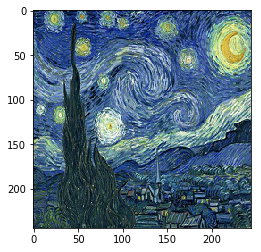

In [3]:
style_img=mpimg.imread(style_img_path)
imgplot = plt.imshow(style_img)
style_img = style_img/255.0 - 0.5

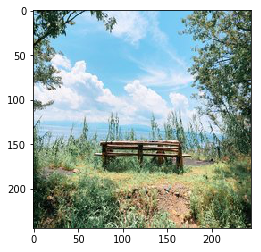

In [4]:
content_img=mpimg.imread(content_img_path)
imgplot = plt.imshow(content_img)
content_img = content_img/255.0 - 0.5

In [49]:
K.clear_session()

class AddReconLayer(layers.Layer):
    '''
        white noise가 content reconstruction이 되도록 특정한 값이 더해주는 레이어
    '''

    def __init__(self, **kwargs):
        super(AddReconLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=input_shape[1:],
            initializer='uniform',
            trainable=True)
        super(AddReconLayer, self).build(input_shape)

    def call(self, x):
        return tf.multiply(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return input_shape

    
class Recon:
    
    def __init__(self, style_img, content_img, style_level, content_level, weight_path, beta, show_summary=False):
        
        self.style_img = style_img
        self.content_img = content_img
        self.style_level = style_level
        self.content_level = content_level
        self.beta = beta
        self.img_size = self.style_img.shape
        self.weight_path = weight_path
        
        # input layers
        input_style_img = Input(shape=self.img_size, name='style_img')
        input_content_img = Input(shape=self.img_size, name='content_img')
        ones = Input(shape=self.img_size, name='ones')
        
        self.recon_layer = AddReconLayer()
        recon_img = self.recon_layer(ones)
        
        # cnn layers
        o = self._make_cnn_layers(style_level, content_level, (input_style_img, input_content_img, recon_img))
        
        self.model = Model([input_style_img, input_content_img, ones], o)
        
        self._set_weights()

        self.model.compile(
            optimizer='rmsprop',
            loss='mean_absolute_error',
            metrics=['mean_absolute_error']) 
        
        if show_summary:
            self.model.summary()
    
    def _make_cnn_layers(self, style_level, content_level, input_layers):
        
        input_style_img, input_content_img, recon_img = input_layers
        
        # CNN Block classes
        
        # Block 1
        block1_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', trainable=False)
        block1_conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', trainable=False)
        block1_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')
        
        # Block 2
        block2_conv1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', trainable=False)
        block2_conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', trainable=False)
        block2_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')
        
        # Block 3
        block3_conv1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', trainable=False)
        block3_conv2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', trainable=False)
        block3_conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', trainable=False)
        block3_conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4', trainable=False)
        block3_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')
        
        # Block 4
        block4_conv1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', trainable=False)
        block4_conv2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', trainable=False)
        block4_conv3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', trainable=False)
        block4_conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4', trainable=False)
        block4_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block4_pool')
        
        # Block 5
        block5_conv1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')
        
        if style_level >= 1:
            f, c, p = block1_conv1(input_style_img), block1_conv1(input_content_img), block1_conv1(recon_img)
            style_loss = self._make_style_loss(f, p, 1)
            
            if content_level == 1:
                 content_loss = self._make_content_loss(c, p)
            
        if style_level >= 2:
            # style loss
            f, c, p = block1_conv2(f), block1_conv2(c), block1_conv2(p)
            f, c, p = block1_pool(f), block1_pool(c), block1_pool(p)
            f, c, p = block2_conv1(f), block2_conv1(c), block2_conv1(p)
            style_loss = layers.Add()([style_loss, self._make_style_loss(f, p, 2)])
            
            if content_level == 2:
                content_loss = self._make_content_loss(c, p)
            
        if style_level >= 3:
            # style loss
            f, c, p = block2_conv2(f), block2_conv2(c), block2_conv2(p)
            f, c, p = block2_pool(f), block2_pool(c), block2_pool(p)
            f, c, p = block3_conv1(f), block3_conv1(c), block3_conv1(p)
            style_loss = layers.Add()([style_loss, self._make_style_loss(f, p, 3)])
            
            if content_level == 3:
                content_loss = self._make_content_loss(c, p)            
        
        if style_level >= 4:
            f, c, p = block3_conv2(f), block3_conv2(c), block3_conv2(p)
            f, c, p = block3_conv3(f), block3_conv3(c), block3_conv3(p)
            f, c, p = block3_conv4(f), block3_conv4(c), block3_conv4(p)
            f, c, p = block3_pool(f), block3_pool(c), block3_pool(p)
            f, c, p = block4_conv1(f), block4_conv1(c), block4_conv1(p)
            style_loss_list.append(self._make_style_loss(f, p, 4))
            
            if content_level == 4:
                content_loss = self._make_content_loss(c, p)            
        
        if style_level == 5:
            f, c, p = block4_conv2(f), block4_conv2(c), block4_conv2(p)
            f, c, p = block4_conv3(f), block4_conv3(c), block4_conv3(p)
            f, c, p = block4_conv4(f), block4_conv4(c), block4_conv4(p)
            f, c, p = block4_pool(f), block4_pool(c), block4_pool(p)
            f, c, p = block5_conv1(f), block5_conv1(c), block5_conv1(p)
            style_loss_list.append(self._make_style_loss(f, p, 5))
            
            if content_level == 5:
                content_loss = self._make_content_loss(c, p)        
        
        return layers.Add()([
            layers.Lambda(lambda x: x*self.beta/self.style_level)(style_loss),
            content_loss])
        
    @staticmethod
    def _make_content_loss(f, p):
        x = layers.Subtract(name='content_loss_subtract')([f, p])
        x = layers.Lambda(lambda x: tf.square(x)/2.0, name='content_loss_sqaure')(x)
        x = layers.Lambda(
            lambda x: tf.reduce_sum(x, keepdims=True), output_shape=(1,1), name='content_loss_sum')(x)
        
        return x
        
    @staticmethod
    def _make_style_loss(f, p, l):
        batch_size, oh, ow, nl = K.int_shape(f)
        
        def outer_product(x):
            x = K.reshape(x, (oh*ow, nl))
            return K.dot(K.transpose(x), x)
        
        def outer_product_output_shape(input_shape):
            return (batch_size, nl, nl)
        
        def mean_square_error(x, y):
            return K.mean(K.square((x - y)/2.0/oh/ow))
        
        def mean_square_error_output_shape(input_shape):
            return (batch_size, 1, 1)
        
        outer_product_wrapper = layers.Lambda(
            lambda x: outer_product(x),
            output_shape=outer_product_output_shape,
            name=f'outer_product_{l}')    
        
        mean_square_error_wrapper = layers.Lambda(
            lambda x: mean_square_error(x[0], x[1]),
            output_shape=mean_square_error_output_shape,
            name=f'mse_{l}')
        
        gf, gp = outer_product_wrapper(f), outer_product_wrapper(p)
    
        return mean_square_error_wrapper([gf, gp])
        
    def _set_weights(self):
        with h5py.File('vgg19_weights_tf_dim_ordering_tf_kernels.h5', 'r') as f:
            for l in self.model.layers:
                if l.name in list(f.keys()) and 'conv' in l.name:
                    w, b = list(f[l.name])
                    w, b = f[l.name][w][:], f[l.name][b][:]
                    l.set_weights([w, b])
    
    def fit(self, epoch=500):
        for i in range(epoch):
            verbose = 0
            if i % 100 == 0:
                print(i)
                verbose = 2
                self.show_img()
                
            self.model.fit(
                {
                    'style_img': np.asarray([self.style_img]), 
                    'content_img': np.asarray([self.content_img]),
                    'ones': np.ones(shape=(1,) + self.img_size, dtype='float32')
                },
                np.zeros((1,1,1), dtype='float32'),
                epochs=1,
                batch_size=1,
                verbose=verbose)
        
        self.show_img()
        
    def show_img(self):
        rec_img = (K.eval(self.recon_layer.kernel)+0.5)*255
        rec_img = np.clip(rec_img, 0, 255).astype('int')
        plt.imshow(rec_img)
        plt.show()

In [52]:
con = Recon(style_img, content_img, style_level=2, content_level=2, weight_path=weight_path, beta=10000.0, show_summary=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ones (InputLayer)               (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
style_img (InputLayer)          (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
add_recon_layer_2 (AddReconLaye (None, 244, 244, 3)  178608      ones[0][0]                       
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 244, 244, 64) 1792        style_img[0][0]                  
                                                                 content_img[0][0]                
          

0


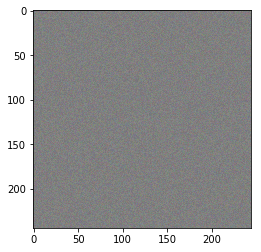

Epoch 1/1
 - 1s - loss: 1572312.6250 - mean_absolute_error: 1572312.6250
100


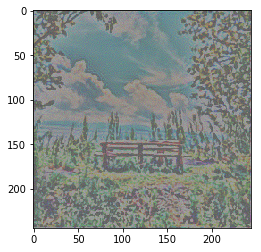

Epoch 1/1
 - 1s - loss: 339473.9062 - mean_absolute_error: 339473.9062
200


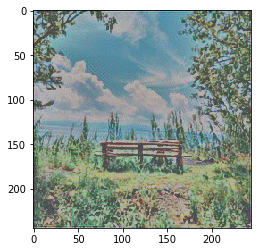

Epoch 1/1
 - 1s - loss: 92829.0234 - mean_absolute_error: 92829.0234
300


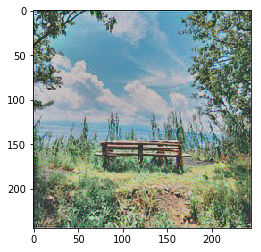

Epoch 1/1
 - 1s - loss: 26891.0039 - mean_absolute_error: 26891.0039
400


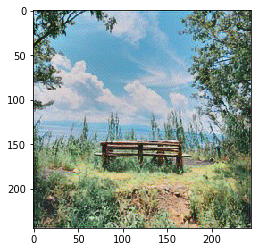

Epoch 1/1
 - 1s - loss: 8694.2598 - mean_absolute_error: 8694.2598
500


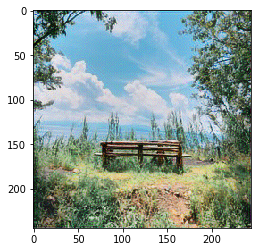

Epoch 1/1
 - 1s - loss: 3690.9165 - mean_absolute_error: 3690.9165
600


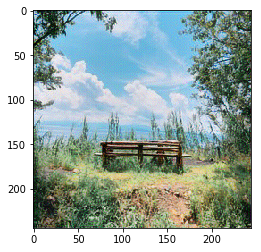

Epoch 1/1
 - 1s - loss: 2066.3242 - mean_absolute_error: 2066.3242


KeyboardInterrupt: 

In [53]:
con.fit(1000)

In [40]:
con.show_img()

AttributeError: 'Recon' object has no attribute 'white_noise'